In [4]:
import torch
import tensorly as tl
import tltorch
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import QuantLib as ql
import itertools
from sklearn.utils.extmath import cartesian

import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch.nn as nn
import torch.optim as optim

In [7]:
tl.set_backend('pytorch')
batch_size = 10000
device = 'cpu'
kf = KFold(n_splits=4, shuffle=True)

sabr_params = ["Strike", "Tenor", "Alpha", "Beta", "Nu", "Rho"]

today = ql.Date(1,1,2022)
ql.Settings.instance().setEvaluationDate(today)
day_counter = ql.Actual365Fixed()

def fdm(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.0, day_counter))
    vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.NullCalendar(), 0.0, day_counter))
    bs_process = ql.GeneralizedBlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(forward)), r_ts, r_ts, vol_ts)
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.impliedVolatility(option.NPV(), bs_process, 1.0e-4, 1000, 1.0e-5, 1.0)

In [8]:
# scaler = MinMaxScaler()

raw_data = pd.read_csv('fdm_hagan_vol_train2.csv')
#raw_data['vol_sqrtT'] = raw_data.apply(lambda x: fdm(1, 1, x.Tenor, x.Alpha, x.Beta, x.Nu_0, x.Rho, 50, 800, 40, eps=.00001) * np.sqrt(x.Tenor), axis=1)
test_raw_data = pd.read_csv('fdm_hagan_vol_test.csv')
raw_data["Error"] = (raw_data["FDM_vol"] - raw_data["Hagan_vol"])
test_raw_data["Error"] = (test_raw_data["FDM_vol"] - test_raw_data["Hagan_vol"])
#raw_data['vol_sqrtT'] = raw_data.apply(lambda x: fdm(1, 1, x.Tenor, x.Alpha, x.Beta, x.Nu_0, x.Rho, 50, 800, 40, eps=.00001) * np.sqrt(x.Tenor), axis=1)

X = raw_data.drop(["FDM_vol", "Hagan_vol", "Error", "Strike", "Nu"], axis=1).values
#X = raw_data.drop(["FDM_vol", "Error", "Strike", "Nu"], axis=1).values
y = raw_data["FDM_vol"].values
X_test = test_raw_data.drop(["FDM_vol", "Hagan_vol", "Error","Strike", "Nu"], axis=1).values
#X_test = test_raw_data.drop(["FDM_vol", "Error","Strike", "Nu"], axis=1).values
y_test = test_raw_data["FDM_vol"].values

valid = test_raw_data.drop(["Hagan_vol", "Error","Strike", "Nu"], axis=1).sample(frac=0.25)
#valid = test_raw_data.drop([ "Error","Strike", "Nu"], axis=1).sample(frac=0.25)
X_valid = valid.drop(["FDM_vol"],axis=1).values
y_valid = valid["FDM_vol"].values

In [9]:
X.shape

(91640, 6)

In [10]:
pd.DataFrame(y).describe()

,0
count,91640.000000
mean,0.062300
std,0.041671
min,0.000919
25%,0.027667
50%,0.060171
75%,0.092113
max,0.204048


In [11]:
(raw_data[raw_data["Strike"]==0])

,Strike,Tenor,Alpha,Beta,Nu,Rho,Strike_0,Nu_0,FDM_vol,Hagan_vol,Error
7,0.0,24.0,0.001,0.400,5.00,0.20,1.0,1.020621,0.001117,0.002959,-0.001841
13,0.0,16.0,0.060,0.150,3.50,-0.40,1.0,0.875000,0.051641,0.105898,-0.054257
67,0.0,6.0,0.065,0.150,0.10,-0.15,1.0,0.040825,0.065106,0.065096,0.000010
126,0.0,1.0,0.005,0.450,4.75,-0.20,1.0,4.750000,0.005658,0.013834,-0.008177
153,0.0,2.0,0.025,0.001,4.75,-0.35,1.0,3.358757,0.024229,0.063369,-0.039140
...,...,...,...,...,...,...,...,...,...,...,...
91564,0.0,0.5,0.005,0.100,2.50,-0.30,1.0,3.535534,0.006074,0.007252,-0.001179
91589,0.0,1.0,0.005,0.010,5.00,0.00,1.0,5.000000,0.005649,0.015417,-0.009767
91598,0.0,6.0,0.001,0.500,1.00,0.35,1.0,0.408248,0.001064,0.001068,-0.000004
91616,0.0,10.0,0.020,0.005,3.00,0.05,1.0,0.948683,0.023985,0.034947,-0.010963


In [12]:
np.mean((raw_data['Error']))

-0.08910731966156143

In [13]:
test_raw_data.drop(["FDM_vol", "Hagan_vol", "Error","Strike", "Nu"], axis=1)

,Tenor,Alpha,Beta,Rho,Strike_0,Nu_0
0,8.035267,0.002014,0.159886,-0.112341,1.010558,1.277430
1,20.041800,0.040062,0.470340,-0.222925,0.755365,1.034644
2,1.187030,0.010698,0.043315,-0.030189,1.004584,0.319243
3,22.602197,0.007096,0.028298,0.214231,0.966880,0.976433
4,13.794197,0.051081,0.474474,0.302402,1.125858,0.820931
...,...,...,...,...,...,...
46392,11.287793,0.015679,0.128551,-0.284883,0.989954,0.424166
46393,4.994133,0.030051,0.201483,-0.193256,1.033057,0.530936
46394,2.349970,0.001508,0.444482,-0.202526,1.001145,2.979326
46395,26.026891,0.073286,0.420669,0.229947,0.513134,0.311996


In [14]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)
y = torch.reshape(y, shape=(-1,1))

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
y_test = torch.reshape(y_test, shape=(-1,1))

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)
y_valid = torch.reshape(y_valid, shape=(-1,1))

In [15]:
X_test.shape

torch.Size([46397, 6])

In [16]:
train_dataset = torch.utils.data.TensorDataset(X, y)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)

In [17]:
len(train_loader.dataset)

91640

In [18]:
model = nn.Sequential(tltorch.FactorizedLinear.from_linear(nn.Linear(6, 25),(2,3),(5,5),factorization='blocktt',rank = 'same'),
                      nn.SiLU(),
                      tltorch.FactorizedLinear((5,5),(10,10),factorization='blocktt',rank = 'same'),
                      nn.SiLU(),
                      tltorch.FactorizedLinear((10,10),(20,20),factorization='blocktt',rank = 'same'),
                      nn.SiLU(),
                      tltorch.FactorizedLinear((20,20),(30,30),factorization='blocktt',rank = 0.5),
                      nn.SiLU(),
                      #tltorch.factorized_layers.TCL((900,),rank=100),
                      nn.Dropout(0.5),
                      tltorch.FactorizedLinear((30,30),(10,10),factorization='blocktt',rank=0.5),   
                      nn.Sigmoid(),
                      tltorch.FactorizedLinear((10,10),(5,5),factorization='blocktt',rank=0.5),   
                      nn.Sigmoid(),
                      tltorch.FactorizedLinear((5,5),(1,1),factorization='blocktt',rank='same'),   
                      nn.Sigmoid()
)

optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999)) 


## do not use lr/scheduler/epoxy too small/batch size/rank scheduler
print(model.zero_grad)
#n_epochs = 100
# batch_size = 64
### use dropout or regularisation layers, validation too
model = model.to(device)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,gamma=0.8,step_size=20)

# model = Sequential()
# model.add(Dense(20, activation='linear', input_shape=(7, )))
# model.add(Dense(100, activation='linear'))
# model.add(Dense(400, activation='sigmoid'))
# model.add(Dense(10, activation='tanh'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='mae', optimizer='adam')

<bound method Module.zero_grad of Sequential(
  (0): FactorizedLinear(in_features=6, out_features=25, weight of size (25, 6) tensorized to ((5, 5), (2, 3)),factorization=BlockTT, rank=[1, 3, 1], with a single layer parametrized, 
  (1): SiLU()
  (2): FactorizedLinear(in_features=25, out_features=100, weight of size (100, 25) tensorized to ((10, 10), (5, 5)),factorization=BlockTT, rank=[1, 6, 1], with a single layer parametrized, 
  (3): SiLU()
  (4): FactorizedLinear(in_features=100, out_features=400, weight of size (400, 100) tensorized to ((20, 20), (10, 10)),factorization=BlockTT, rank=[1, 13, 1], with a single layer parametrized, 
  (5): SiLU()
  (6): FactorizedLinear(in_features=400, out_features=900, weight of size (900, 400) tensorized to ((30, 30), (20, 20)),factorization=BlockTT, rank=[1, 16, 1], with a single layer parametrized, 
  (7): SiLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): FactorizedLinear(in_features=900, out_features=100, weight of size (100, 900) tensorized t

In [19]:
# model = nn.Sequential(tltorch.FactorizedLinear.from_linear(nn.Linear(6, 20),(2,3),(4,5),factorization='blocktt',rank = 'same'),
#                       nn.SiLU(),
#                       tltorch.FactorizedLinear.from_linear(nn.Linear(20, 100),(4,5),(10,10),factorization='blocktt',rank = 'same'),
#                       nn.SiLU(),
#                       tltorch.FactorizedLinear.from_linear(nn.Linear(100, 400),(10,10),(20,20),factorization='blocktt',rank = 0.5),
#                       nn.SiLU(),
#                       tltorch.FactorizedLinear.from_linear(nn.Linear(400, 900),(20,20),(30,30),factorization='blocktt',rank = 0.5),
#                       nn.Sigmoid(),
#                       #tltorch.factorized_layers.TCL(input_shape=(8581,1000),rank=(10,10)),
#                       tltorch.FactorizedLinear((900,30),(10,10),factorization='blocktt',rank=0.5),   
#                       nn.Sigmoid(),
#                       tltorch.FactorizedLinear((10,10),(5,5),factorization='blocktt',rank=0.5),   
#                       nn.Sigmoid(),
#                       tltorch.FactorizedLinear((5,5),(1,1),factorization='blocktt',rank='same'),   
#                       nn.Tanh() ## why tanh! 
#                       ### expand later and have full rank while using low rank at the start so that you can trickle down there faster
# )

In [23]:
# def train():
#     model.train()
#     for i, (features, error) in enumerate(train_loader):
#         features, error = features.to(device), error.to(device)
#         optimizer.zero_grad()
#         output = model(features)
#         loss = torch.nn.functional.mse_loss(output,error)
#         loss.backward()
#         optimizer.step()
#         if i % 1000 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, i * len(features), len(train_loader.dataset),
#                 100. * i / len(train_loader), loss))

# def test():
#     model.eval()
#     test_loss = 0
#     correct = 0
#     for features, error in test_loader:
#         features, error = features.to(device), error.to(device)
#         output = model(features)
#         test_loss = torch.nn.functional.mse_loss(output,error)
#         pred = output.data.max(1, keepdim=True)[1]
#         correct += pred.eq(error.data.view_as(pred)).cpu().sum()

#     test_loss /= len(test_loader.dataset)
#     print('mean: {}'.format(test_loss))
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#        100. * correct / len(test_loader.dataset)))
n_epochs = 200
valid_loss=0.0
min_valid_loss = 10000
#train_loss=0.0
optimizer = optim.Adam(model.parameters(),lr=0.0005,betas=(0.9,0.999))
for epoch in range(n_epochs):
    for i, (features, error) in enumerate(train_loader):
        features, error = features.to(device), error.to(device)
        optimizer.zero_grad()
        output = model(features)
        loss = torch.nn.functional.smooth_l1_loss(output,error)
                #mse_loss(output,error)
        loss.backward()
        optimizer.step()
        #train_loss += loss.item()
        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.9f}'.format(
                epoch, i * len(features), len(train_loader.dataset),
                100. * i / len(train_loader), loss))
    
    for j, (f, e) in enumerate(valid_loader):
        o = model(f)
        l = torch.nn.functional.mse_loss(o,e)
        valid_loss += l.item()
        if j % 10 == 0:
            print('Valid Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.9f}'.format(
                epoch, j * len(f), len(valid_loader.dataset),
                100. * j / len(valid_loader), l))

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model.state_dict(),'validatedmodel2.pt') 

    valid_loss=0.0
    #scheduler.step()
    #print(scheduler.get_last_lr())
    #train_loss=0.0



torch.save(model.state_dict(),'tensormodel6.pt') 

Train Epoch: 0 [0/91640 (0%)]	Loss: 0.000000260
Train Epoch: 0 [2560/91640 (3%)]	Loss: 0.000002795
Train Epoch: 0 [5120/91640 (6%)]	Loss: 0.000000996
Train Epoch: 0 [7680/91640 (8%)]	Loss: 0.000000318
Train Epoch: 0 [10240/91640 (11%)]	Loss: 0.000000338
Train Epoch: 0 [12800/91640 (14%)]	Loss: 0.000000254
Train Epoch: 0 [15360/91640 (17%)]	Loss: 0.000000268
Train Epoch: 0 [17920/91640 (20%)]	Loss: 0.000000292
Train Epoch: 0 [20480/91640 (22%)]	Loss: 0.000000233
Train Epoch: 0 [23040/91640 (25%)]	Loss: 0.000000309
Train Epoch: 0 [25600/91640 (28%)]	Loss: 0.000000265
Train Epoch: 0 [28160/91640 (31%)]	Loss: 0.000000375
Train Epoch: 0 [30720/91640 (34%)]	Loss: 0.000000241
Train Epoch: 0 [33280/91640 (36%)]	Loss: 0.000000312
Train Epoch: 0 [35840/91640 (39%)]	Loss: 0.000000300
Train Epoch: 0 [38400/91640 (42%)]	Loss: 0.000000356
Train Epoch: 0 [40960/91640 (45%)]	Loss: 0.000000309
Train Epoch: 0 [43520/91640 (47%)]	Loss: 0.000000333
Train Epoch: 0 [46080/91640 (50%)]	Loss: 0.000000383
Trai

In [24]:
y

tensor([[0.0702],
        [0.0475],
        [0.0762],
        ...,
        [0.0842],
        [0.0578],
        [0.0018]])

In [25]:
#torch.save(model.state_dict(),'tensormodel6.pt') 
model.load_state_dict(torch.load('tensormodel6.pt'))

<All keys matched successfully>

In [26]:
model.state_dict()

OrderedDict([('0.bias',
              tensor([-0.2140,  0.7273,  0.8589, -0.4123, -0.1474, -0.1349, -0.2338, -0.6960,
                      -0.8107,  0.6230,  0.2323,  0.0479,  0.2939, -0.5751,  0.3324,  0.1689,
                      -0.3516, -1.1079, -0.2105,  1.6617, -0.1188, -0.0422, -0.6787,  1.0124,
                      -0.7552])),
             ('0.weight.factors.factor_0',
              tensor([[[[ 0.4950,  0.5693, -0.0219],
                        [-0.6701, -0.1101,  0.4123]],
              
                       [[-0.8060, -0.1561,  0.1505],
                        [-0.4508,  0.4772, -0.1288]],
              
                       [[ 1.1078, -0.4755, -0.5083],
                        [-0.1969,  0.4340, -0.0192]],
              
                       [[-1.0555, -0.3961,  0.4351],
                        [-0.4672,  0.3209,  0.5207]],
              
                       [[-0.1155, -0.1287,  0.1337],
                        [ 0.4408,  0.2417,  0.7939]]]])),
             ('0.w

In [27]:
model(X_test).detach().numpy()

In [28]:
test_loss = 0
sum = 0

for features, error in test_loader:
        features, error = features.to(device), error.to(device)
        output = model(features)
        test_loss = torch.nn.functional.smooth_l1_loss(output,error)
        sum += test_loss
        print(test_loss)

mean_test_loss = 64*sum/len(test_loader.dataset)
print('mean: {}'.format(mean_test_loss))
# print('\nTest set: Average loss: {:.9f}, Accuracy: {}/{} ({:.6f}%)\n'.format(\
#     test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))


tensor(4.8525e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.2307e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.3154e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(2.9558e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(2.9731e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.8418e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.7251e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.1940e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.4325e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.2114e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.3534e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.7346e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.6717e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.3654e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.1512e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.2398e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.9900e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.9901e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(4.4276e-07, grad_fn=<SmoothL1LossBackward0>)
tensor(3.790

In [30]:
pred = model(X_test)

In [31]:
test_raw_data['pred'] = pred.detach().numpy()
test_raw_data['Error_my'] = test_raw_data['FDM_vol'] - test_raw_data['pred']
test_raw_data

,Strike,Tenor,Alpha,Beta,Nu,Rho,Strike_0,Nu_0,FDM_vol,Hagan_vol,Error,pred,Error_my
0,1.840131,8.035267,0.002014,0.159886,3.621073,-0.112341,1.010558,1.277430,0.004302,0.010288,-0.005986,0.002174,0.002128
1,-1.564301,20.041800,0.040062,0.470340,4.631902,-0.222925,0.755365,1.034644,0.065054,0.313356,-0.248302,0.065962,-0.000909
2,0.392427,1.187030,0.010698,0.043315,0.347818,-0.030189,1.004584,0.319243,0.010795,0.010793,0.000002,0.010558,0.000237
3,-0.998365,22.602197,0.007096,0.028298,4.642133,0.214231,0.966880,0.976433,0.010767,0.036381,-0.025614,0.008967,0.001801
4,0.624853,13.794197,0.051081,0.474474,3.048982,0.302402,1.125858,0.820931,0.069177,0.127465,-0.058288,0.068739,0.000438
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46392,-0.191673,11.287793,0.015679,0.128551,1.425082,-0.284883,0.989954,0.424166,0.018276,0.018955,-0.000679,0.019464,-0.001188
46393,0.484277,4.994133,0.030051,0.201483,1.186511,-0.193256,1.033057,0.530936,0.032543,0.032915,-0.000371,0.032354,0.000189
46394,0.495020,2.349970,0.001508,0.444482,4.567192,-0.202526,1.001145,2.979326,0.002016,0.005294,-0.003278,0.001776,0.000240
46395,-1.784588,26.026891,0.073286,0.420669,1.591696,0.229947,0.513134,0.311996,0.119108,0.143509,-0.024402,0.118736,0.000372


In [32]:
pred0 = model(X).detach().numpy()
raw_data['pred0'] = pred0
raw_data['FDM_vol'] - raw_data['pred0']

In [33]:
import xgboost as xg
model2 = xg.XGBRegressor(n_estimators=5000, max_depth=5, eta=0.01, subsample=0.5, colsample_bytree=0.7,eval_metric=['rmse','mae'],verbose=2)
model2.fit(X, raw_data['FDM_vol'] - raw_data['pred0'])

[01:56:05] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             eta=0.01, eval_metric=['rmse', 'mae'], gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=2, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbose=2, ...)

In [34]:
model2.save_model("model_xgb.json")
import xgboost as xg
#model2 = xg.XGBRegressor(n_estimators=5000, max_depth=5, eta=0.01, subsample=0.5, colsample_bytree=0.7,eval_metric=['rmse','mae'],verbose=2)
model2.load_model("model_xgb.json")

In [35]:
test_raw_data['pred_new'] = test_raw_data['pred'] + model2.predict(X_test)

In [26]:
test_raw_data['Error_my']

In [27]:
model2.predict(X_test)

In [42]:
test_raw_data['binStrike'] = pd.cut(test_raw_data['Strike'],[-2, -1.75, -1.5, -1.25, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 1.25, 1.5, 1.75, 2])
test_raw_data['binTenor'] = pd.cut(test_raw_data['Tenor'],[0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 21, 24, 27, 30])
test_raw_data['binAlpha'] = pd.cut(test_raw_data['Alpha'],[.001, .01, .02, .03, .04, .05, .06, .07, .08, .09])
test_raw_data['binBeta'] = pd.cut(test_raw_data['Beta'],[.001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
test_raw_data['binNu'] = pd.cut(test_raw_data['Nu'],[.1, .5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
test_raw_data['binRho'] = pd.cut(test_raw_data['Rho'],[-.4, -.35, -.3, -.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25, .3, .35, .4])
tt = test_raw_data.drop(['Strike','Tenor','Alpha','Beta','Nu','Rho','Strike_0','Nu_0','Error','FDM_vol','Hagan_vol','pred'],axis=1)
tt['ErrPred'] = np.abs(test_raw_data['FDM_vol'] - test_raw_data['pred'])
tt['ErrPredNew'] = np.abs(test_raw_data['FDM_vol'] - test_raw_data['pred_new'])
tt['ErrHagan'] = np.abs(test_raw_data['FDM_vol'] - test_raw_data['Hagan_vol'])
tt['FDM'] = test_raw_data['FDM_vol']
tt

,Error_my,pred_new,binStrike,binTenor,binAlpha,binBeta,binNu,binRho,ErrPred,ErrPredNew,ErrHagan,FDM
0,0.002128,0.002365,"(1.75, 2.0]","(8.0, 9.0]","(0.001, 0.01]","(0.15, 0.2]","(3.5, 4.0]","(-0.15, -0.1]",0.002128,1.937353e-03,0.005986,0.004302
1,-0.000909,0.065830,"(-1.75, -1.5]","(18.0, 21.0]","(0.04, 0.05]","(0.45, 0.5]","(4.5, 5.0]","(-0.25, -0.2]",0.000909,7.763434e-04,0.248302,0.065054
2,0.000237,0.010618,"(0.25, 0.5]","(1.0, 1.5]","(0.01, 0.02]","(0.001, 0.05]","(0.1, 0.5]","(-0.05, 0.0]",0.000237,1.777241e-04,0.000002,0.010795
3,0.001801,0.008794,"(-1.0, -0.75]","(21.0, 24.0]","(0.001, 0.01]","(0.001, 0.05]","(4.5, 5.0]","(0.2, 0.25]",0.001801,1.973211e-03,0.025614,0.010767
4,0.000438,0.068596,"(0.5, 0.75]","(12.0, 14.0]","(0.05, 0.06]","(0.45, 0.5]","(3.0, 3.5]","(0.3, 0.35]",0.000438,5.813794e-04,0.058288,0.069177
...,...,...,...,...,...,...,...,...,...,...,...,...
46392,-0.001188,0.019417,"(-0.25, 0.0]","(10.0, 12.0]","(0.01, 0.02]","(0.1, 0.15]","(1.0, 1.5]","(-0.3, -0.25]",0.001188,1.140909e-03,0.000679,0.018276
46393,0.000189,0.032543,"(0.25, 0.5]","(4.0, 5.0]","(0.03, 0.04]","(0.2, 0.25]","(1.0, 1.5]","(-0.2, -0.15]",0.000189,2.060890e-07,0.000371,0.032543
46394,0.000240,0.001724,"(0.25, 0.5]","(2.0, 3.0]","(0.001, 0.01]","(0.4, 0.45]","(4.5, 5.0]","(-0.25, -0.2]",0.000240,2.919065e-04,0.003278,0.002016
46395,0.000372,0.118171,"(-2.0, -1.75]","(24.0, 27.0]","(0.07, 0.08]","(0.4, 0.45]","(1.5, 2.0]","(0.2, 0.25]",0.000372,9.360553e-04,0.024402,0.119108


In [43]:
np.mean(np.abs(tt['ErrPred']))

0.0006508514355412519

In [44]:
np.mean(np.abs(tt['ErrPredNew']))

0.0006230171675526257

In [45]:
tt.groupby(['binStrike']).agg({'ErrPred':['mean','max'],'ErrPredNew':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrPredNew 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 mean 
 max 
 
 
 binStrike 
 
 
 
 
 
 
 
 
 
 
 (-2.0, -1.75] 
 0.000723 
 0.004733 
 0.000685 
 0.004907 
 0.110908 
 0.748647 
 
 
 (-1.75, -1.5] 
 0.000694 
 0.004220 
 0.000648 
 0.004018 
 0.105213 
 0.701668 
 
 
 (-1.5, -1.25] 
 0.000676 
 0.005149 
 0.000633 
 0.005248 
 0.093490 
 0.597315 
 
 
 (-1.25, -1.0] 
 0.000639 
 0.004098 
 0.000604 
 0.004250 
 0.077548 
 0.565430 
 
 
 (-1.0, -0.75] 
 0.000640 
 0.003891 
 0.000606 
 0.003956 
 0.066216 
 0.508624 
 
 
 (-0.75, -0.5] 
 0.000632 
 0.003905 
 0.000605 
 0.003925 
 0.055887 
 0.406441 
 
 
 (-0.5, -0.25] 
 0.000637 
 0.004025 
 0.000618 
 0.004317 
 0.044190 
 0.334411 
 
 
 (-0.25, 0.0] 
 0.000634 
 0.003954 
 0.000620 
 0.004177 
 0.034568 
 0.222697 
 
 
 (0.0, 0.25] 
 0.000633 
 0.004102 
 0.000629 
 0.004104 
 0.033290 
 0.230298 
 
 
 (0.25, 0.5] 
 0.000624 
 0.004709 
 0.000606 
 0.004810 
 0.042307 
 0.297745 
 
 
 (0.5, 0.75] 
 0.000611 
 0.004528 
 0.000591 
 0.004496 
 0.051464 
 0.380506 
 
 
 (0.75, 1.0] 
 0.000626 
 0.003773 
 0.000596 
 0.003729 
 0.062842 
 0.446289 
 
 
 (1.0, 1.25] 
 0.000638 
 0.003948 
 0.000612 
 0.003951 
 0.074080 
 0.496900 
 
 
 (1.25, 1.5] 
 0.000667 
 0.004198 
 0.000636 
 0.004181 
 0.078577 
 0.534168 
 
 
 (1.5, 1.75] 
 0.000666 
 0.005100 
 0.000640 
 0.005396 
 0.091369 
 0.569855 
 
 
 (1.75, 2.0] 
 0.000673 
 0.004625 
 0.000641 
 0.004461 
 0.102171 
 0.652169

In [46]:
tt.groupby(['binTenor']).agg({'ErrPred':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 
 
 binTenor 
 
 
 
 
 
 
 
 
 (0.5, 1.0] 
 0.000774 
 0.004704 
 0.060301 
 0.561041 
 
 
 (1.0, 1.5] 
 0.000726 
 0.005100 
 0.061884 
 0.629190 
 
 
 (1.5, 2.0] 
 0.000701 
 0.004268 
 0.071607 
 0.583571 
 
 
 (2.0, 3.0] 
 0.000665 
 0.004375 
 0.069637 
 0.544004 
 
 
 (3.0, 4.0] 
 0.000678 
 0.004418 
 0.068543 
 0.612120 
 
 
 (4.0, 5.0] 
 0.000644 
 0.003646 
 0.068984 
 0.577960 
 
 
 (5.0, 6.0] 
 0.000656 
 0.004340 
 0.070330 
 0.538132 
 
 
 (6.0, 7.0] 
 0.000651 
 0.005149 
 0.073516 
 0.677176 
 
 
 (7.0, 8.0] 
 0.000642 
 0.003948 
 0.070822 
 0.694293 
 
 
 (8.0, 9.0] 
 0.000637 
 0.003875 
 0.068253 
 0.650924 
 
 
 (9.0, 10.0] 
 0.000608 
 0.004134 
 0.068488 
 0.623468 
 
 
 (10.0, 12.0] 
 0.000632 
 0.004173 
 0.069350 
 0.728485 
 
 
 (12.0, 14.0] 
 0.000631 
 0.004709 
 0.074352 
 0.652169 
 
 
 (14.0, 16.0] 
 0.000619 
 0.004226 
 0.072484 
 0.728030 
 
 
 (16.0, 18.0] 
 0.000631 
 0.004303 
 0.071262 
 0.626191 
 
 
 (18.0, 21.0] 
 0.000643 
 0.004321 
 0.071561 
 0.699196 
 
 
 (21.0, 24.0] 
 0.000639 
 0.004706 
 0.068179 
 0.736691 
 
 
 (24.0, 27.0] 
 0.000663 
 0.004733 
 0.071486 
 0.748647 
 
 
 (27.0, 30.0] 
 0.000688 
 0.004087 
 0.070767 
 0.701668

In [47]:
tt.groupby(['binAlpha']).agg({'ErrPred':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 
 
 binAlpha 
 
 
 
 
 
 
 
 
 (0.001, 0.01] 
 0.000953 
 0.004340 
 0.006655 
 0.069499 
 
 
 (0.01, 0.02] 
 0.001303 
 0.005149 
 0.020759 
 0.144108 
 
 
 (0.02, 0.03] 
 0.000460 
 0.002156 
 0.036743 
 0.228439 
 
 
 (0.03, 0.04] 
 0.000493 
 0.002508 
 0.051923 
 0.308997 
 
 
 (0.04, 0.05] 
 0.000503 
 0.002608 
 0.069379 
 0.428278 
 
 
 (0.05, 0.06] 
 0.000513 
 0.002613 
 0.083216 
 0.482755 
 
 
 (0.06, 0.07] 
 0.000530 
 0.002653 
 0.100796 
 0.555105 
 
 
 (0.07, 0.08] 
 0.000559 
 0.003777 
 0.114960 
 0.661918 
 
 
 (0.08, 0.09] 
 0.000604 
 0.004704 
 0.131307 
 0.748647

In [48]:
tt.groupby(['binNu']).agg({'ErrPred':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 
 
 binNu 
 
 
 
 
 
 
 
 
 (0.1, 0.5] 
 0.000662 
 0.004709 
 0.000040 
 0.000741 
 
 
 (0.5, 1.0] 
 0.000649 
 0.004321 
 0.000707 
 0.011867 
 
 
 (1.0, 1.5] 
 0.000640 
 0.004080 
 0.004270 
 0.043432 
 
 
 (1.5, 2.0] 
 0.000648 
 0.003683 
 0.013506 
 0.108982 
 
 
 (2.0, 2.5] 
 0.000654 
 0.004704 
 0.029361 
 0.161232 
 
 
 (2.5, 3.0] 
 0.000639 
 0.004528 
 0.052158 
 0.235111 
 
 
 (3.0, 3.5] 
 0.000653 
 0.005100 
 0.080350 
 0.324140 
 
 
 (3.5, 4.0] 
 0.000645 
 0.005149 
 0.114922 
 0.462613 
 
 
 (4.0, 4.5] 
 0.000651 
 0.004260 
 0.156868 
 0.611214 
 
 
 (4.5, 5.0] 
 0.000668 
 0.004706 
 0.204652 
 0.748647

In [49]:
tt.groupby(['binBeta']).agg({'ErrPred':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 
 
 binBeta 
 
 
 
 
 
 
 
 
 (0.001, 0.05] 
 0.000647 
 0.004709 
 0.070246 
 0.699196 
 
 
 (0.05, 0.1] 
 0.000660 
 0.004346 
 0.069954 
 0.652659 
 
 
 (0.1, 0.15] 
 0.000651 
 0.004260 
 0.073713 
 0.748647 
 
 
 (0.15, 0.2] 
 0.000640 
 0.003940 
 0.067470 
 0.642850 
 
 
 (0.2, 0.25] 
 0.000652 
 0.005149 
 0.069552 
 0.701668 
 
 
 (0.25, 0.3] 
 0.000639 
 0.005100 
 0.070599 
 0.736691 
 
 
 (0.3, 0.35] 
 0.000651 
 0.004625 
 0.069739 
 0.728030 
 
 
 (0.35, 0.4] 
 0.000651 
 0.004733 
 0.070697 
 0.692153 
 
 
 (0.4, 0.45] 
 0.000656 
 0.004303 
 0.071747 
 0.728485 
 
 
 (0.45, 0.5] 
 0.000661 
 0.004704 
 0.070272 
 0.668659

In [50]:
tt.groupby(['binRho']).agg({'ErrPred':['mean','max'],'ErrHagan':['mean','max']})

ErrPred 
 ErrHagan 
 
 
 
 mean 
 max 
 mean 
 max 
 
 
 binRho 
 
 
 
 
 
 
 
 
 (-0.4, -0.35] 
 0.000660 
 0.004706 
 0.066540 
 0.631405 
 
 
 (-0.35, -0.3] 
 0.000645 
 0.004418 
 0.065867 
 0.660382 
 
 
 (-0.3, -0.25] 
 0.000652 
 0.004303 
 0.070922 
 0.701668 
 
 
 (-0.25, -0.2] 
 0.000625 
 0.004221 
 0.071839 
 0.728485 
 
 
 (-0.2, -0.15] 
 0.000673 
 0.004704 
 0.072010 
 0.677176 
 
 
 (-0.15, -0.1] 
 0.000641 
 0.005149 
 0.075624 
 0.643673 
 
 
 (-0.1, -0.05] 
 0.000665 
 0.004080 
 0.074512 
 0.736691 
 
 
 (-0.05, 0.0] 
 0.000640 
 0.004346 
 0.076673 
 0.694293 
 
 
 (0.0, 0.05] 
 0.000649 
 0.004070 
 0.078014 
 0.748647 
 
 
 (0.05, 0.1] 
 0.000635 
 0.004375 
 0.074992 
 0.692153 
 
 
 (0.1, 0.15] 
 0.000640 
 0.004087 
 0.070705 
 0.641975 
 
 
 (0.15, 0.2] 
 0.000672 
 0.005100 
 0.071371 
 0.638025 
 
 
 (0.2, 0.25] 
 0.000643 
 0.004102 
 0.068523 
 0.567864 
 
 
 (0.25, 0.3] 
 0.000644 
 0.004216 
 0.062959 
 0.618104 
 
 
 (0.3, 0.35] 
 0.000657 
 0.004733 
 0.062859 
 0.542166 
 
 
 (0.35, 0.4] 
 0.000670 
 0.004709 
 0.062587 
 0.575604

In [51]:
test_raw_data[['pred','FDM_vol','pred_new']]

,pred,FDM_vol,pred_new
0,0.002174,0.004302,0.002365
1,0.065962,0.065054,0.065830
2,0.010558,0.010795,0.010618
3,0.008967,0.010767,0.008794
4,0.068739,0.069177,0.068596
...,...,...,...
46392,0.019464,0.018276,0.019417
46393,0.032354,0.032543,0.032543
46394,0.001776,0.002016,0.001724
46395,0.118736,0.119108,0.118171


In [52]:
print(np.max(abs(test_raw_data['pred'] - test_raw_data['FDM_vol']))) ## expand training set/range of set
## give it more data in these ranges - stratify based on loss (also with memory)
## loss functions - optimise on mae
## use percentile
print(np.max(abs(test_raw_data['pred_new'] - test_raw_data['FDM_vol'])))

0.00514908165356202
0.005395947984817493


In [53]:
np.mean(abs(test_raw_data['pred'] - test_raw_data['FDM_vol']))
np.mean(abs(test_raw_data['pred_new'] - test_raw_data['FDM_vol']))

0.0006230171675526257

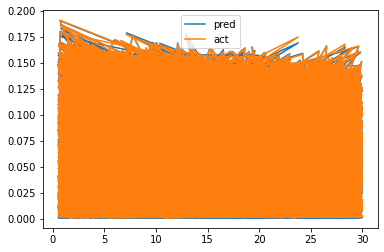

In [45]:
plt.plot(test_raw_data['Tenor'],test_raw_data['pred'],label='pred')
plt.plot(test_raw_data['Tenor'],test_raw_data['FDM_vol'],label='act')
plt.legend()

In [54]:
mse = ((test_raw_data['pred']-test_raw_data['FDM_vol'])**2).mean()
mse2 = ((test_raw_data['pred_new']-test_raw_data['FDM_vol'])**2).mean()
print(mse,mse2)

7.666328357971411e-07 7.17472615249035e-07


In [55]:
rmse = mse**0.5
rmse2 = mse2**0.5
print(rmse,rmse2)

0.0008755757167699097 0.0008470375524432403


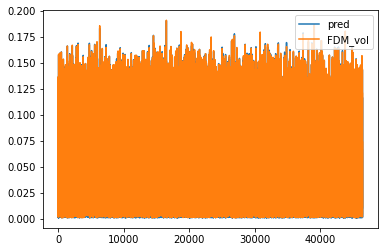

In [48]:
test_raw_data[['pred','FDM_vol']].plot()

In [44]:
# make predictions with the model
X_test.requires_grad_(True)
# yhat = model(X_train)
yhat = model(X_test)
deriv = torch.autograd.grad(outputs = [yhat], inputs = [X_test], grad_outputs = torch.ones_like(yhat) ,
                                  allow_unused=True, retain_graph=True, create_graph=True)[0]

In [45]:
deriv.shape

torch.Size([46397, 6])

In [56]:
param_names = ["Strike", "Tenor", "Alpha", "Beta", "Nu", "Rho"]
today = ql.Date(1,1,2022)
ql.Settings.instance().setEvaluationDate(today)
day_counter = ql.Actual365Fixed()
def fdm_price(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, 0, day_counter))
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.NPV()

def fdm(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.0, day_counter))
    vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.NullCalendar(), 0.0, day_counter))
    bs_process = ql.GeneralizedBlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(forward)), r_ts, r_ts, vol_ts)
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.impliedVolatility(option.NPV(), bs_process, 1.0e-4, 1000, 1.0e-5, 1.0)

In [93]:
f = 100
T = 2
alpha = 0.02
beta = 0.2
nu = 2.0
rho = 0.2
strike_range = np.linspace(-1, 1, 100)
model_results_2 = model(torch.tensor(np.array([[T, alpha, beta, rho, np.exp(strike * alpha * T**.5), nu / T**.5] for strike in strike_range]),requires_grad=True).float())
fdm_results_2 = np.array([fdm(np.exp(strike * alpha * T**.5), 1, T, alpha, beta, nu / T**.5, rho, 50, 800, 40, eps=.00001) for strike in strike_range])
hagan_results_2 = np.array([ql.sabrVolatility(np.exp(strike * alpha * T**.5), 1, T, alpha, beta, nu / T**.5, rho) for strike in strike_range])

In [94]:
from scipy.interpolate import CubicSpline
model_res_fin = np.polyfit(np.array(strike_range), model_results_2.detach().numpy()[:,0],3)

In [95]:
model_res_fin_2 = model_res_fin[0]*strike_range**3 + model_res_fin[1]*strike_range**2 + model_res_fin[2]*strike_range**1 + model_res_fin[3]

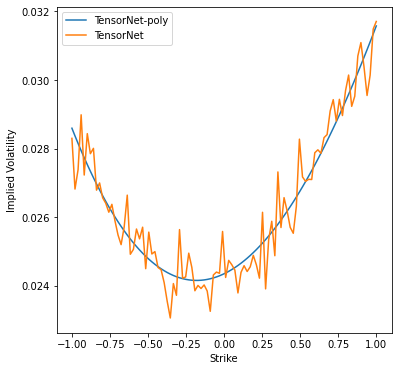

In [96]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
axes.plot(strike_range, model_res_fin_2, label="TensorNet-poly")
axes.plot(strike_range, model_results_2.detach().numpy(), label="TensorNet")
#axes.plot(strike_range, fdm_results_2, label="fdm")
#axes.plot(strike_range, hagan_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Strike")
axes.set_ylabel("Implied Volatility")

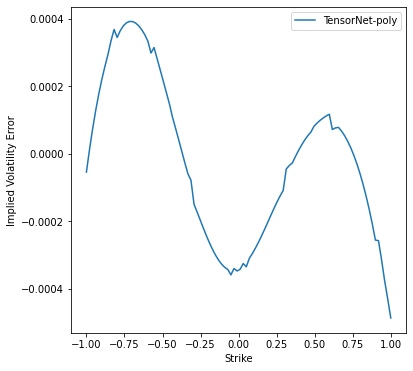

In [97]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
axes.plot(strike_range, fdm_results_2 - model_res_fin_2, label="TensorNet-poly")
#axes.plot(strike_range, model_results_2.detach().numpy(), label="TensorNet")
#axes.plot(strike_range, fdm_results_2 - hagan_results_2, label="hagan")
#axes.plot(strike_range, fdm_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Strike")
axes.set_ylabel("Implied Volatility Error")

In [79]:
f = 200
strike = 0
alpha = 0.06
beta = 0.3
nu = 3
rho = -0.3
time_range = np.linspace(0.5, 30, 100)
model_results_2 = model(torch.tensor(np.array([[T, alpha, beta, rho, np.exp(strike * alpha * T**.5), nu / T**.5] for T in time_range]),requires_grad=True).float())
fdm_results_2 = np.array([fdm(np.exp(strike * alpha * T**.5), 1, T, alpha, beta, nu / T**.5, rho, 50, 800, 40, eps=.00001) for T in time_range])
hagan_results_2 = np.array([ql.sabrVolatility(np.exp(strike * alpha * T**.5), 1, T, alpha, beta, nu / T**.5, rho) for T in time_range])

In [80]:
from scipy.interpolate import CubicSpline
model_res_fin = np.polyfit(np.array(time_range), model_results_2.detach().numpy()[:,0],3)

In [81]:
model_res_fin_2 = model_res_fin[0]*time_range**3 + model_res_fin[1]*time_range**2 + model_res_fin[2]*time_range**1 + model_res_fin[3]

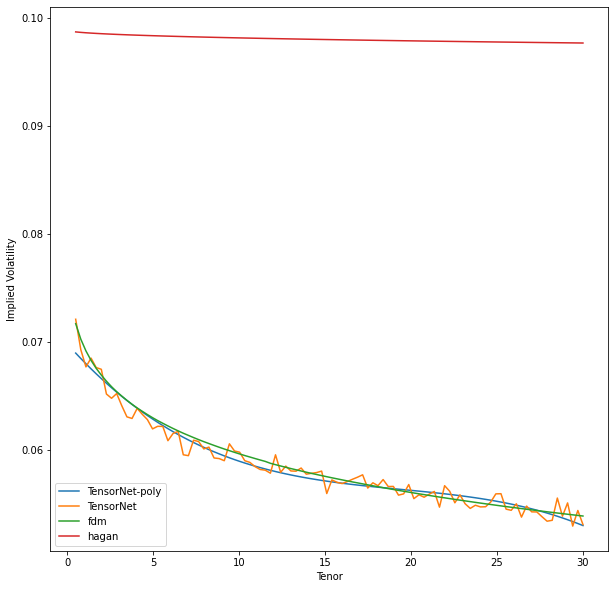

In [82]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 10))
axes.plot(time_range, model_res_fin_2, label="TensorNet-poly")
axes.plot(time_range, model_results_2.detach().numpy(), label="TensorNet")
axes.plot(time_range, fdm_results_2, label="fdm")
axes.plot(time_range, hagan_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Tenor")
axes.set_ylabel("Implied Volatility")

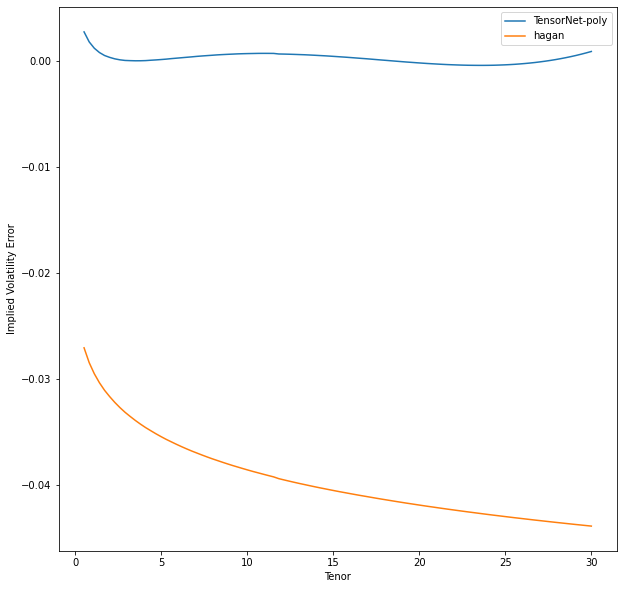

In [84]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 10))
axes.plot(time_range, fdm_results_2 - model_res_fin_2, label="TensorNet-poly")
#axes.plot(strike_range, model_results_2.detach().numpy(), label="TensorNet")
axes.plot(time_range, fdm_results_2 - hagan_results_2, label="hagan")
#axes.plot(strike_range, fdm_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Tenor")
axes.set_ylabel("Implied Volatility Error")

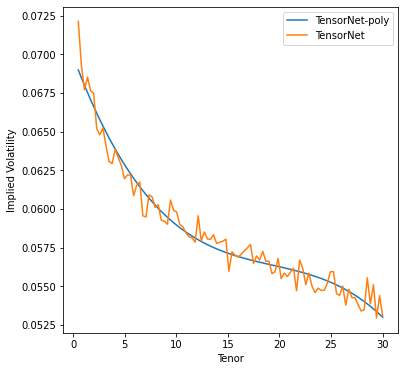

In [85]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
axes.plot(time_range, model_res_fin_2, label="TensorNet-poly")
axes.plot(time_range, model_results_2.detach().numpy(), label="TensorNet")
#axes.plot(time_range, fdm_results_2, label="fdm")
#axes.plot(time_range, hagan_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Tenor")
axes.set_ylabel("Implied Volatility")

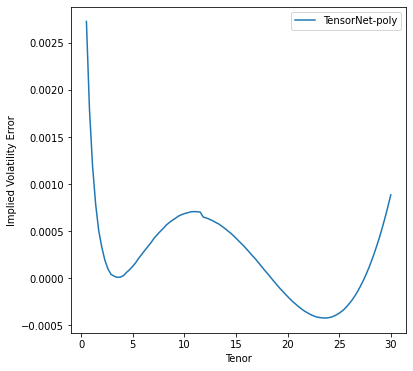

In [86]:
fig, axes = plt.subplots(ncols=1, figsize=(6, 6))
axes.plot(time_range, fdm_results_2 - model_res_fin_2, label="TensorNet-poly")
#axes.plot(strike_range, model_results_2.detach().numpy(), label="TensorNet")
#axes.plot(time_range, fdm_results_2 - hagan_results_2, label="hagan")
#axes.plot(strike_range, fdm_results_2, label="hagan")
axes.legend()
axes.set_xlabel("Tenor")
axes.set_ylabel("Implied Volatility Error")

In [69]:
sdef greeks(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    # delta_k = (
    #     fdm_price(strike + .01, forward, tenor, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    #     - fdm_price(strike - .01, forward, tenor, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    # ) * 50
    delta_f = (
        fdm_price(strike, forward + .001, tenor, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
        - fdm_price(strike, forward - .001, tenor, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    ) * 500
    theta = (
        fdm_price(strike, forward, tenor + 1/365, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
        - fdm_price(strike, forward, tenor - 1/365, alpha, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    ) * 365/2
    vega = (
        fdm_price(strike, forward, tenor, alpha + .001, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
        - fdm_price(strike, forward, tenor, alpha - .001, beta, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    ) * 500
    # rho_b = (
    #     fdm_price(strike, forward, tenor, alpha, beta + .001, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    #     - fdm_price(strike, forward, tenor, alpha, beta - .001, nu, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    # ) * 500
    # rho_n = (
    #     fdm_price(strike, forward, tenor, alpha, beta, nu + .01, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    #     - fdm_price(strike, forward, tenor, alpha, beta, nu - .01, rho, t_grid, f_grid, x_grid, scaling_factor, eps)
    # ) * 50
    # rho_r = (
    #     fdm_price(strike, forward, tenor, alpha, beta, nu, rho + .001, t_grid, f_grid, x_grid, scaling_factor, eps)
    #     - fdm_price(strike, forward, tenor, alpha, beta, nu, rho - .001, t_grid, f_grid, x_grid, scaling_factor, eps)
    # ) * 500
    # return delta_k, delta_f, theta, vega, rho_b, rho_n, rho_r
    return delta_f, theta, vega

In [0]:
data = test_raw_data.drop(["FDM_vol", "Hagan_vol", "Error","Strike", "Nu"], axis=1)
extremes = np.array([[np.min(data.values[:, i]), np.max(data.values[:, i])] for i in range(6)])
strike = np.random.uniform(extremes[0, 0], extremes[0, 1])
tenor = np.random.uniform(extremes[1, 0], extremes[1, 1])
alpha = np.random.uniform(extremes[2, 0], extremes[2, 1])
beta = np.random.uniform(extremes[3, 0], extremes[3, 1])
nu = np.random.uniform(extremes[4, 0], extremes[4, 1])
rho = np.random.uniform(extremes[5, 0], extremes[5, 1])
fdm_greeks = greeks(np.exp(strike * alpha * tenor**.5), 1, tenor, alpha, beta, nu / tenor**.5, rho, 40, 400, 50)

In [74]:
import QuantLib as ql
today = ql.Date(1,1,2022)
ql.Settings.instance().setEvaluationDate(today)
day_counter = ql.Actual365Fixed()

def fdm_price(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, 0, day_counter))
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.NPV()

In [0]:
today = ql.Date(1,1,2022)
ql.Settings.instance().setEvaluationDate(today)
day_counter = ql.Actual365Fixed()

def fdm(strike, forward, tenor, alpha, beta, nu, rho, t_grid=20, f_grid=200, x_grid=25, scaling_factor=1.0, eps=.0001):
    maturity_date = today + ql.Period(int(round(365 * tenor)), ql.Days)
    r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.0, day_counter))
    vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.NullCalendar(), 0.0, day_counter))
    bs_process = ql.GeneralizedBlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(forward)), r_ts, r_ts, vol_ts)
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(maturity_date))
    option.setPricingEngine(ql.FdSabrVanillaEngine(forward, alpha, beta, nu, rho, r_ts, t_grid, f_grid, x_grid, 0, scaling_factor, eps))
    return option.impliedVolatility(option.NPV(), bs_process, 1.0e-4, 1000, 1.0e-5, 1.0)